In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from modelo import ModeloSKL
%matplotlib inline

# Carga Datos

In [2]:
tipos = {"fecha": str, "hora": int, "temperatura": float, "humedad": float, "presion": float, "direccion_viento": float, "velocidad_viento": float, "estacion": str}
data = pd.read_csv("clima_bsas.csv",dtype=tipos)
del data["Unnamed: 0"]
data.head(2)

,fecha,hora,temperatura,humedad,presion,direccion_viento,velocidad_viento,estacion
0,01062021,0,16.7,53.0,1012.6,290.0,15.0,AEROPARQUE AERO
1,01062021,1,15.5,66.0,1012.1,320.0,9.0,AEROPARQUE AERO


In [3]:
print(data.shape)
data.dtypes

(87280, 8)


fecha                object
hora                  int64
temperatura         float64
humedad             float64
presion             float64
direccion_viento    float64
velocidad_viento    float64
estacion             object
dtype: object

# Preparación datos

In [4]:
print(data.shape)
datana = data.dropna()
datana.shape

(87280, 8)


(87251, 8)

In [5]:
aero = datana[datana["estacion"] == "AEROPARQUE AERO"].copy()
aero.shape
del aero["estacion"]
aero.dtypes

fecha                object
hora                  int64
temperatura         float64
humedad             float64
presion             float64
direccion_viento    float64
velocidad_viento    float64
dtype: object

In [6]:
aero["fecha"] = pd.to_datetime(aero["fecha"],format="%d%m%Y") #+  pd.to_timedelta(aero.hora, unit='h')
aero["dia"] = aero["fecha"].dt.day
aero["mes"] = aero["fecha"].dt.month
aero["año"] = aero["fecha"].dt.year
aero.sort_values(by=["fecha"],inplace=True)
aero.reset_index(inplace=True)
promedios_aero = aero.groupby("fecha").mean().reset_index().sort_values(by="fecha")
del promedios_aero["index"]
aero.dtypes

index                        int64
fecha               datetime64[ns]
hora                         int64
temperatura                float64
humedad                    float64
presion                    float64
direccion_viento           float64
velocidad_viento           float64
dia                          int64
mes                          int64
año                          int64
dtype: object

In [7]:
aero_prom = aero.join(promedios_aero.set_index("fecha"),on="fecha",rsuffix="_prom")
del aero_prom["hora_prom"]
del aero_prom["index"]
aero_prom.sort_values(by=["fecha","hora"],inplace=True)


In [8]:
promedios_aero["fecha"] = promedios_aero["fecha"] + pd.Timedelta(-1,unit="day")
predictor = None
predictor = aero.join(promedios_aero.set_index("fecha"),on="fecha",rsuffix="_prom_dia_sig")
del predictor["index"]
del predictor["hora_prom_dia_sig"]
del predictor["mes_prom_dia_sig"]
del predictor["dia_prom_dia_sig"]
del predictor["año_prom_dia_sig"]
promedios_aero["fecha"] = promedios_aero["fecha"] + pd.Timedelta(1,unit="day")



In [9]:
max_aero = aero.groupby("fecha").max().reset_index().sort_values(by="fecha")
min_aero = aero.groupby("fecha").min().reset_index().sort_values(by="fecha")
max_aero["fecha"] = max_aero["fecha"] + pd.Timedelta(-1,unit="day")
min_aero["fecha"] = min_aero["fecha"] + pd.Timedelta(-1,unit="day")

predictor = predictor.join(max_aero.set_index("fecha"),on="fecha",rsuffix="_max_dia_sig")
predictor = predictor.join(min_aero.set_index("fecha"),on="fecha",rsuffix="_min_dia_sig")
del predictor["index"]
del predictor["hora_max_dia_sig"]
del predictor["mes_max_dia_sig"]
del predictor["dia_max_dia_sig"]
del predictor["año_max_dia_sig"]
del predictor["hora_min_dia_sig"]
del predictor["mes_min_dia_sig"]
del predictor["dia_min_dia_sig"]
del predictor["año_min_dia_sig"]
predictor.dropna(inplace=True)
predictor.sort_values(by="fecha",inplace=True)
predictor.columns

Index(['fecha', 'hora', 'temperatura', 'humedad', 'presion',
       'direccion_viento', 'velocidad_viento', 'dia', 'mes', 'año',
       'temperatura_prom_dia_sig', 'humedad_prom_dia_sig',
       'presion_prom_dia_sig', 'direccion_viento_prom_dia_sig',
       'velocidad_viento_prom_dia_sig', 'temperatura_max_dia_sig',
       'humedad_max_dia_sig', 'presion_max_dia_sig',
       'direccion_viento_max_dia_sig', 'velocidad_viento_max_dia_sig',
       'index_min_dia_sig', 'temperatura_min_dia_sig', 'humedad_min_dia_sig',
       'presion_min_dia_sig', 'direccion_viento_min_dia_sig',
       'velocidad_viento_min_dia_sig'],
      dtype='object')

# Modelos predecir temperatura

In [10]:
predictor.columns

Index(['fecha', 'hora', 'temperatura', 'humedad', 'presion',
       'direccion_viento', 'velocidad_viento', 'dia', 'mes', 'año',
       'temperatura_prom_dia_sig', 'humedad_prom_dia_sig',
       'presion_prom_dia_sig', 'direccion_viento_prom_dia_sig',
       'velocidad_viento_prom_dia_sig', 'temperatura_max_dia_sig',
       'humedad_max_dia_sig', 'presion_max_dia_sig',
       'direccion_viento_max_dia_sig', 'velocidad_viento_max_dia_sig',
       'index_min_dia_sig', 'temperatura_min_dia_sig', 'humedad_min_dia_sig',
       'presion_min_dia_sig', 'direccion_viento_min_dia_sig',
       'velocidad_viento_min_dia_sig'],
      dtype='object')

In [11]:
modelo = ModeloSKL()
modelo.splitear(["temperatura_max_dia_sig","temperatura_min_dia_sig"],predictor)


{'test': 0.7133976961741921, 'train': 0.8699739509983204}


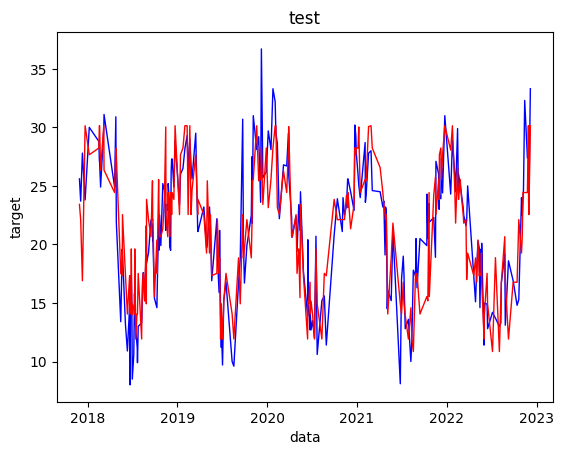

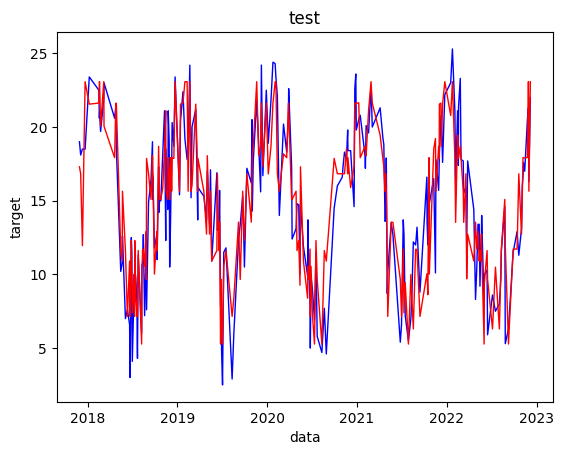

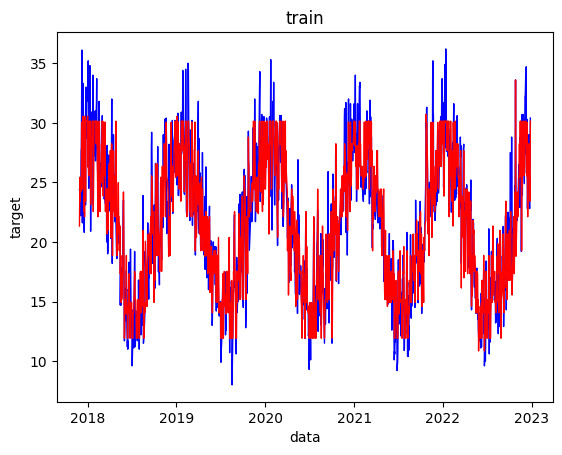

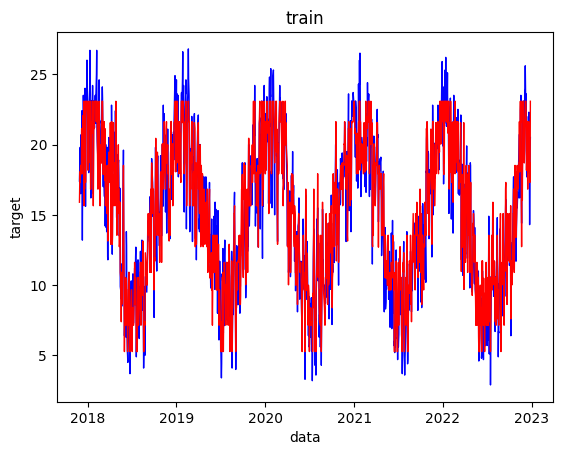

In [12]:
import sklearn.tree
from sklearn.tree import DecisionTreeRegressor

print(modelo.setear_modelo(DecisionTreeRegressor,max_depth=6))
modelo.plotear_perf()
tree = modelo.modelo

{'test': 0.22670866672725332, 'train': 0.3286455720546369}


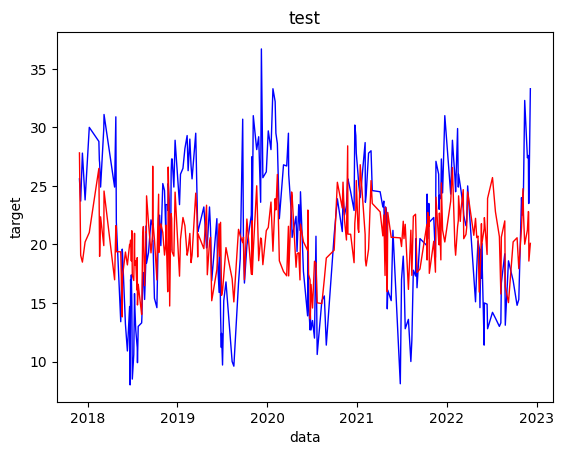

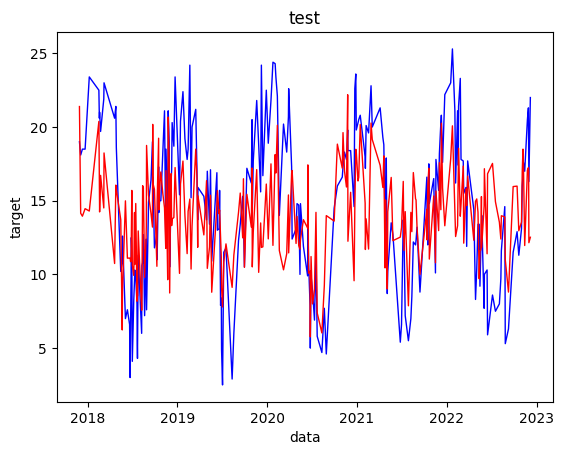

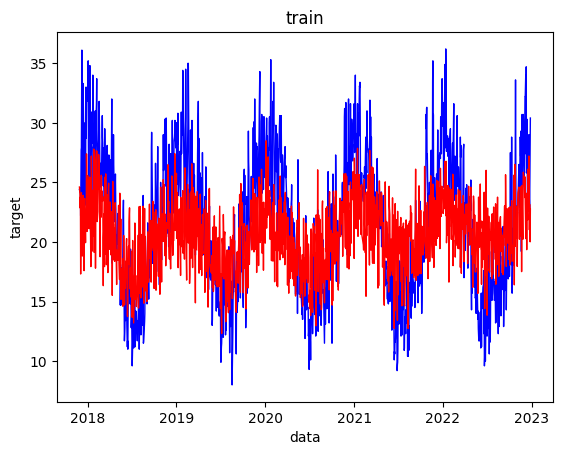

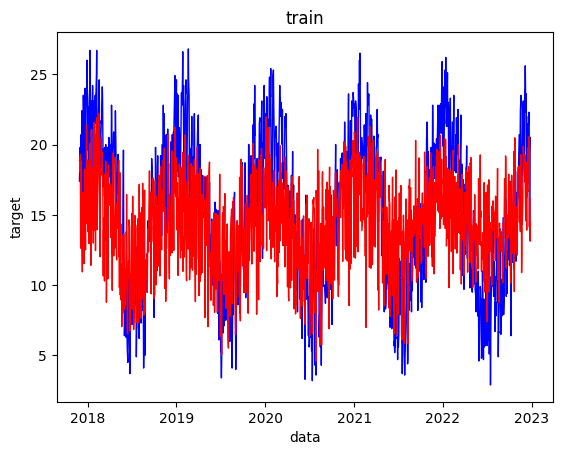

In [13]:
from sklearn.neighbors import KNeighborsRegressor
print(modelo.setear_modelo(KNeighborsRegressor,n_neighbors=10))
modelo.plotear_perf()
knn = modelo.modelo

{'test': 0.8178289174353732, 'train': 0.9762802199547611}


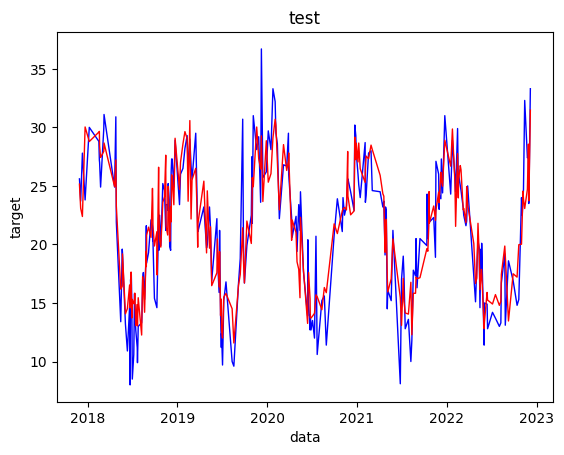

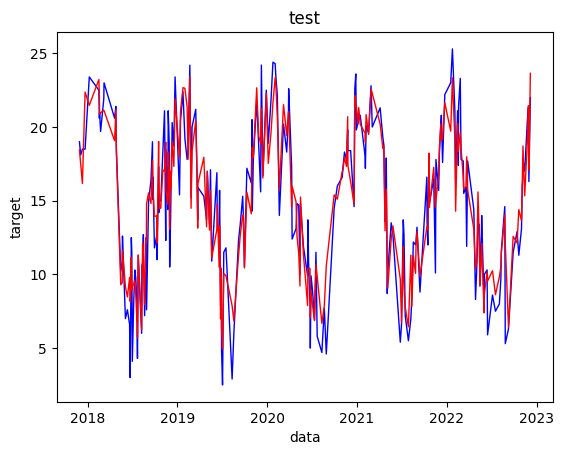

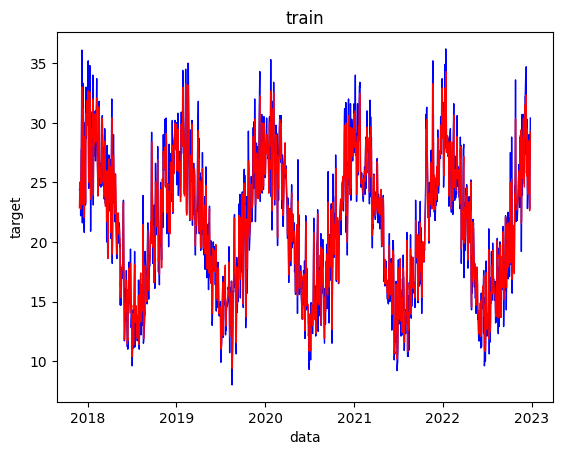

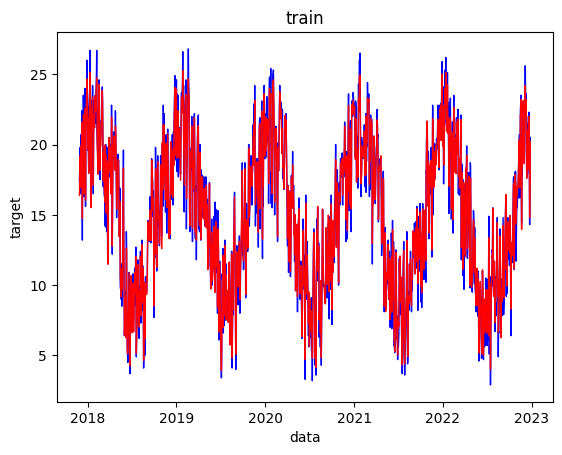

In [14]:
from sklearn.ensemble import RandomForestRegressor
print(modelo.setear_modelo(RandomForestRegressor)) # max_depth=10
modelo.plotear_perf()
forest = modelo.modelo
modelo.exportar_modelo()

{'test': 0.7807115818941275, 'train': 0.8254908290783101}


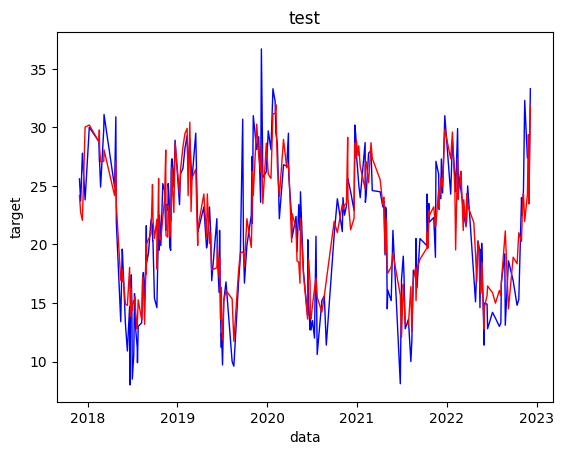

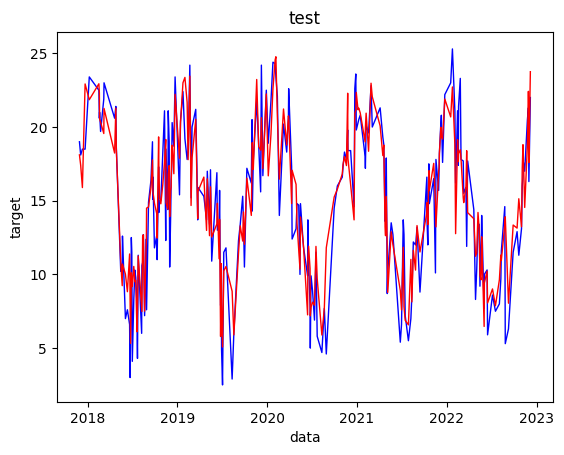

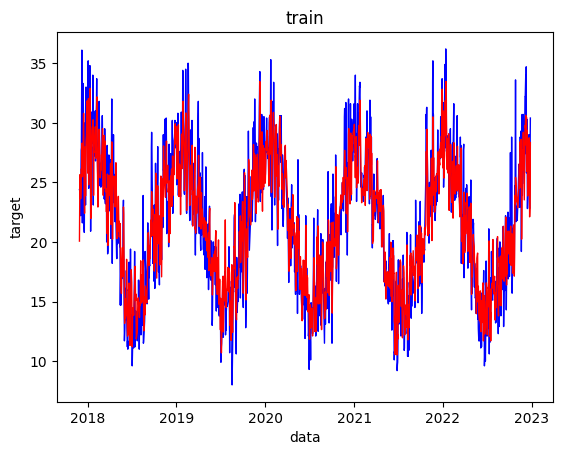

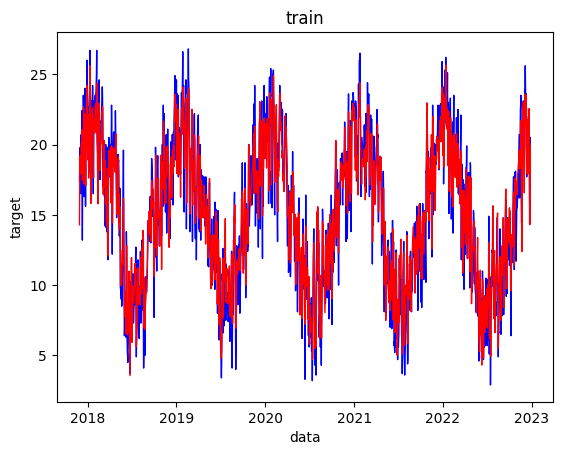

In [15]:
from sklearn.linear_model import Lasso
print(modelo.setear_modelo(Lasso))
modelo.plotear_perf()
lasso = modelo.modelo

{'test': 0.7838150600964248, 'train': 0.8307958008297515}


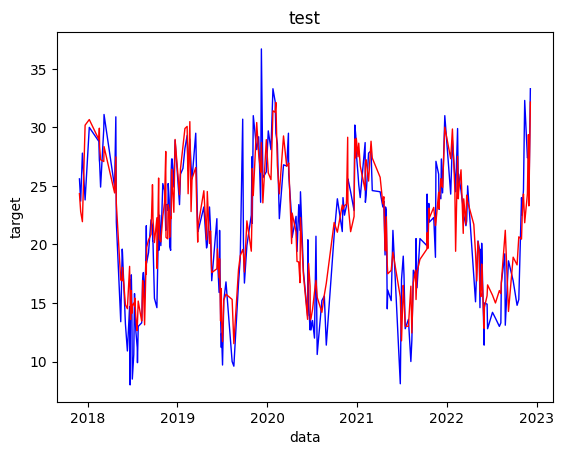

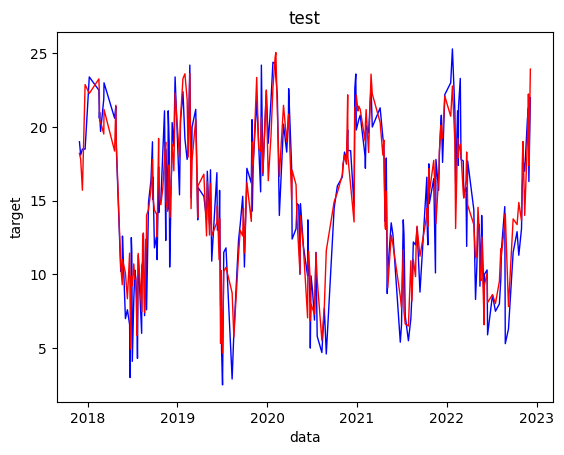

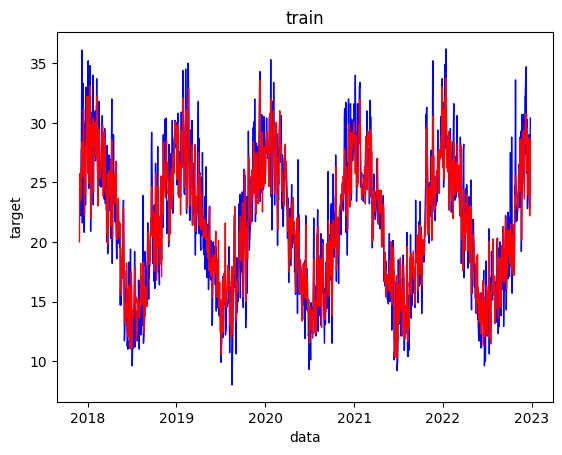

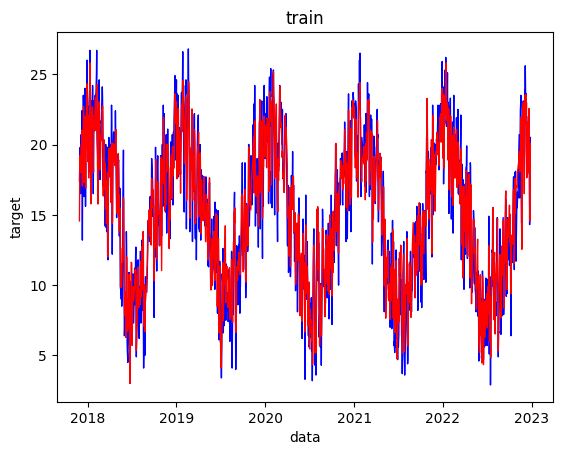

In [16]:
from sklearn.linear_model import ElasticNet
print(modelo.setear_modelo(ElasticNet))
modelo.plotear_perf()
elastic_net = modelo.modelo

{'test': 0.7790732747791997, 'train': 0.84136249105458}


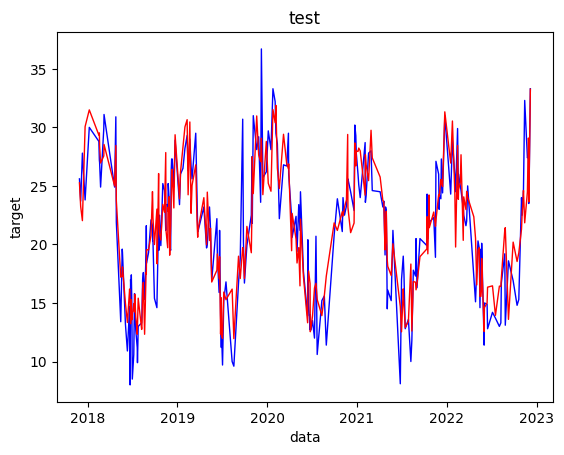

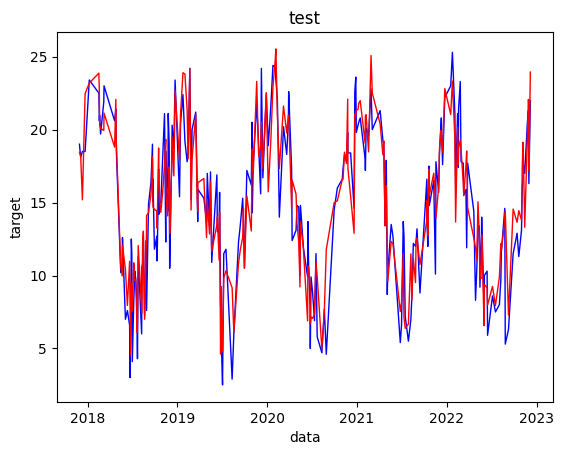

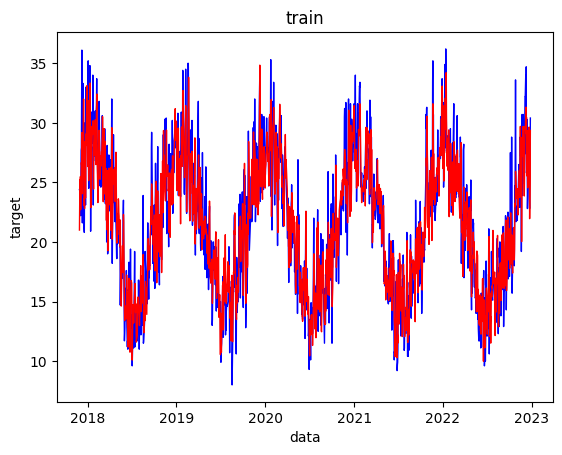

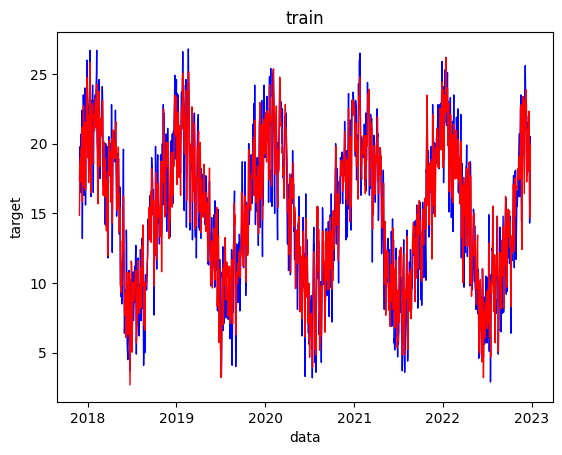

In [17]:
from sklearn.linear_model import Ridge
print(modelo.setear_modelo(Ridge))
modelo.plotear_perf()
ridge = modelo.modelo

# modelos humedad

In [18]:
predictor.columns

Index(['fecha', 'hora', 'temperatura', 'humedad', 'presion',
       'direccion_viento', 'velocidad_viento', 'dia', 'mes', 'año',
       'temperatura_prom_dia_sig', 'humedad_prom_dia_sig',
       'presion_prom_dia_sig', 'direccion_viento_prom_dia_sig',
       'velocidad_viento_prom_dia_sig', 'temperatura_max_dia_sig',
       'humedad_max_dia_sig', 'presion_max_dia_sig',
       'direccion_viento_max_dia_sig', 'velocidad_viento_max_dia_sig',
       'index_min_dia_sig', 'temperatura_min_dia_sig', 'humedad_min_dia_sig',
       'presion_min_dia_sig', 'direccion_viento_min_dia_sig',
       'velocidad_viento_min_dia_sig'],
      dtype='object')

In [19]:
modelo_hum = ModeloSKL()
modelo_hum.splitear(a_predecir="humedad_prom_dia_sig",dataset=predictor)

{'test': 0.48628953955257925, 'train': 0.5674017966498648}


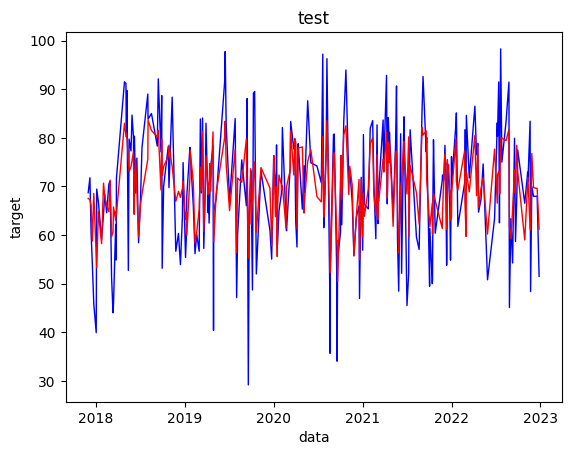

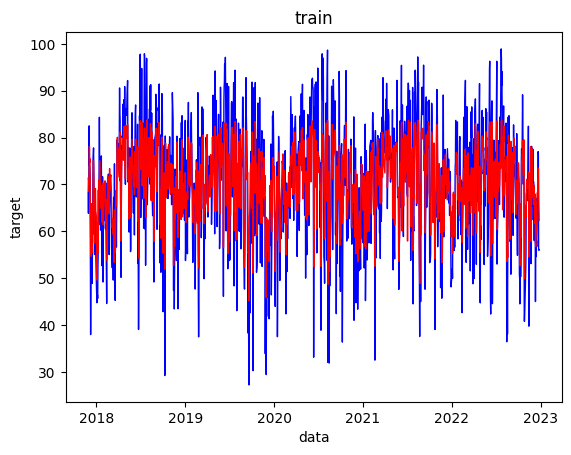

In [20]:
print(modelo_hum.setear_modelo(RandomForestRegressor,max_depth=4,max_leaf_nodes=150))
modelo_hum.plotear_perf()

{'test': 0.295645875459264, 'train': 0.4660684764629507}


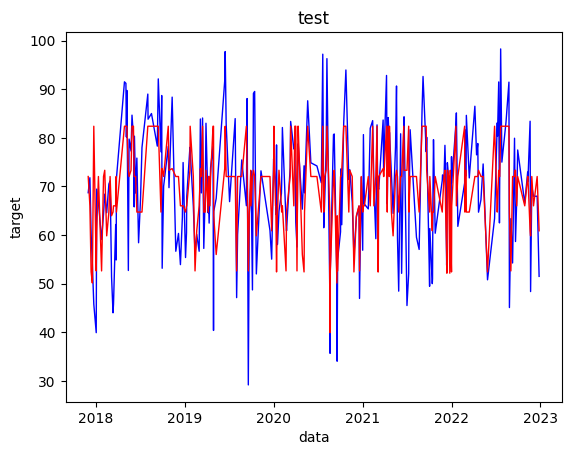

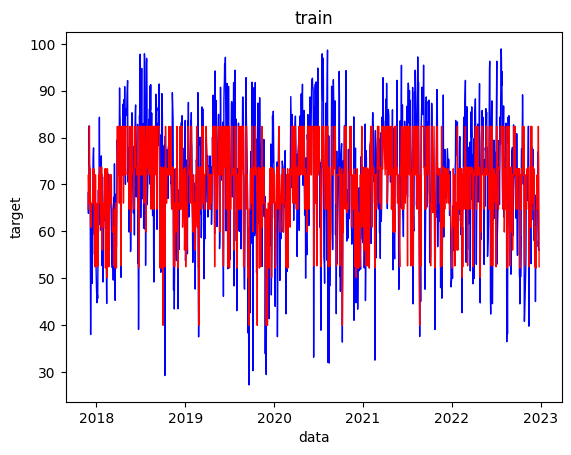

4

In [21]:
print(modelo_hum.setear_modelo(DecisionTreeRegressor,max_depth=4))
modelo_hum.plotear_perf()
modelo_hum.modelo.get_depth()

In [22]:
print(modelo_hum.setear_modelo(Lasso))
# modelo_hum.plotear_perf()

{'test': 0.5102094573979103, 'train': 0.4907095246402543}


In [23]:
print(modelo_hum.setear_modelo(ElasticNet))


{'test': 0.5041136375448612, 'train': 0.49699077484819265}
